<a href="https://colab.research.google.com/github/Asm3515/Resume_Predictor/blob/main/Trial_resume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="color:White; display:fill; border-radius:5px;background-color:#336b87;font-size:200%;font-family:sans-serif;letter-spacing:0.5px;text-align: center">TOP#3 Career choice predictor</div>

In [1]:
import zipfile
import os

zip_file_path = '/content/archive (19).zip'
extracted_dir = '/content/archive'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

<div style="color:White; display:fill; border-radius:5px;background-color:#336b87;font-size:200%;font-family:sans-serif;letter-spacing:0.5px;text-align: center">Essential Libraries</div>

In [2]:
#import libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report
from collections import Counter
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

#classifier
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# load resume.csv dataset using by pandas.
data=pd.read_csv('/content/archive/Resume/Resume.csv')

# Split the data into train and test sets
resume_data, resume_test_data = train_test_split(data, test_size=0.15,stratify=data['Category'], random_state=42)

# Save the test data to CSV files
resume_test_data.to_csv('test_resume_data.csv', index=False)


In [4]:
# resume data overview
resume_data.head()

ID                                         Resume_str  \
1443  16066857           SENIOR EXECUTIVE CHEF           Execu...   
56    52979663           SENIOR HR             Highlights     ...   
1131  15281412           CONSULTANT       Summary    Transitio...   
2472  16279537           SUPERVISORY LOGISTICS MANAGEMENT SPEC...   
1710  24647794           ENGINEERING INTERN           Profile ...   

                                            Resume_html     Category  
1443  <div class="fontsize fontface vmargins hmargin...         CHEF  
56    <div class="fontsize fontface vmargins hmargin...           HR  
1131  <div class="fontsize fontface vmargins hmargin...   CONSULTANT  
2472  <div class="fontsize fontface vmargins hmargin...     AVIATION  
1710  <div class="fontsize fontface vmargins hmargin...  ENGINEERING

In [5]:
resume_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2111 entries, 1443 to 1999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2111 non-null   int64 
 1   Resume_str   2111 non-null   object
 2   Resume_html  2111 non-null   object
 3   Category     2111 non-null   object
dtypes: int64(1), object(3)
memory usage: 82.5+ KB


Here we see, there are 4 columns such as ID, Resume_str, Resume_html, and Category. Category columns are our target columns, and the rest of the target columns are used to train the model.

In [6]:
# Check how much data is available for our training model.
resume_data.shape

(2111, 4)

Now I want to check how many categories are in the Categories columns for our model.

In [7]:
resume_data['Category'].unique()

array(['CHEF', 'HR', 'CONSULTANT', 'AVIATION', 'ENGINEERING', 'BANKING',
       'BUSINESS-DEVELOPMENT', 'ADVOCATE', 'FINANCE', 'DIGITAL-MEDIA',
       'CONSTRUCTION', 'HEALTHCARE', 'DESIGNER', 'AGRICULTURE', 'ARTS',
       'FITNESS', 'TEACHER', 'PUBLIC-RELATIONS', 'APPAREL',
       'INFORMATION-TECHNOLOGY', 'ACCOUNTANT', 'SALES', 'BPO',
       'AUTOMOBILE'], dtype=object)

Let's see how many different classes of resumes we have in our dataset using the value_counts() method of pandas library.

In [8]:
# check how many resume are available in every category.
resume_data['Category'].value_counts()

BUSINESS-DEVELOPMENT      102
INFORMATION-TECHNOLOGY    102
CHEF                      100
ENGINEERING               100
ADVOCATE                  100
FINANCE                   100
ACCOUNTANT                100
AVIATION                   99
SALES                      99
FITNESS                    99
CONSULTANT                 98
BANKING                    98
HEALTHCARE                 98
CONSTRUCTION               95
PUBLIC-RELATIONS           94
HR                         93
DESIGNER                   91
ARTS                       88
TEACHER                    87
APPAREL                    82
DIGITAL-MEDIA              82
AGRICULTURE                54
AUTOMOBILE                 31
BPO                        19
Name: Category, dtype: int64

In [9]:
len(resume_data['Category'].value_counts())

24

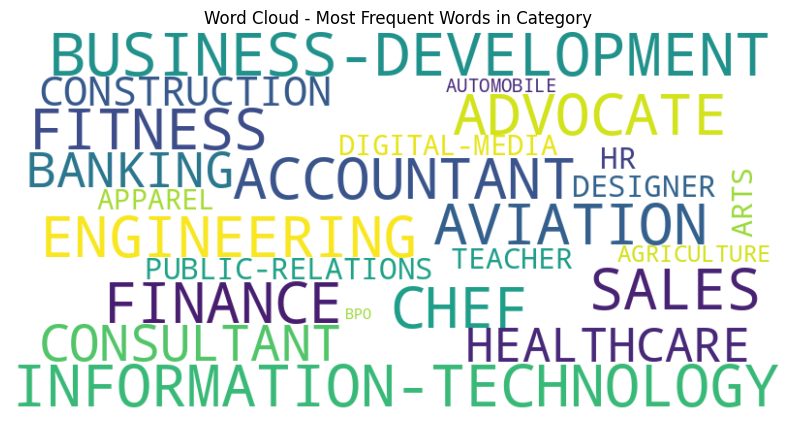

In [11]:
# Combine text from Category columns
combined_text = ' '.join(resume_data['Category'])

# Tokenize and count word frequency
word_counts = Counter(combined_text.split())

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Most Frequent Words in Category')
plt.show()

<div style="color:White; display:fill; border-radius:5px;background-color:#336b87;font-size:200%;font-family:sans-serif;letter-spacing:0.5px;text-align: center">Handling Missing Values and Text Cleaning</div>

That means there are no missing values in our data set.

We need to apply some data cleaning before vectorizing our text data. Just a quick reminder, in NLP, we need to convert text data to numbers before applying any machine learning. That process is called the vectorization of the text data.

Let's have a quick look at one of the resumes to better understand what types of steps we need to perform.

Now, we can observe the presence of unnecessary elements in the text data, including dots, commas, excessive spaces, consecutive underscores, links, numbers, and other extraneous characters.


## Cleaning function
This code performs the following steps:

* Removes links (URLs) using regular expressions.
* Removes punctuation and special characters using regular expressions.
* Removes extra spaces and underscores.
* Removes numbers using regular expressions.
* Converts the text to lowercase.
* Removes leading and trailing spaces.
* Removes Stopwords.

and If someone is using the "Resume_html" column for this analysis, then he must clean html tags
* Removes HTML Tags.

In [12]:

def resume_cleaning(text):

    # Remove HTML tags
    cleaned_text = re.sub(r'<.*?>', ' ', text)

    # Remove non-english characters, punctuation,special characters, digits, continous underscores and extra whitespace
    cleaned_text = re.sub('[^a-zA-Z]', ' ', cleaned_text)
    cleaned_text = re.sub(r'[^\w\s]|_', ' ', cleaned_text)
    cleaned_text = re.sub(r'\d+', ' ', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    cleaned_text=re.sub('http\S+\s', " ", cleaned_text)



    # Convert to lowercase
    cleaned_text = cleaned_text.lower()

    # Tokenize the cleaned text
    words = word_tokenize(cleaned_text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]

    # Tokenize the cleaned text
    words = word_tokenize(cleaned_text)

    # Apply stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    cleaned_text = ' '.join(stemmed_words)

    return cleaned_text




In [13]:
#now apply text cleaning function in my dataset
resume_data['Cleaned_Resume']=resume_data['Resume_str'].apply(lambda x:resume_cleaning(x))

In [14]:
resume_data.head()

ID                                         Resume_str  \
1443  16066857           SENIOR EXECUTIVE CHEF           Execu...   
56    52979663           SENIOR HR             Highlights     ...   
1131  15281412           CONSULTANT       Summary    Transitio...   
2472  16279537           SUPERVISORY LOGISTICS MANAGEMENT SPEC...   
1710  24647794           ENGINEERING INTERN           Profile ...   

                                            Resume_html     Category  \
1443  <div class="fontsize fontface vmargins hmargin...         CHEF   
56    <div class="fontsize fontface vmargins hmargin...           HR   
1131  <div class="fontsize fontface vmargins hmargin...   CONSULTANT   
2472  <div class="fontsize fontface vmargins hmargin...     AVIATION   
1710  <div class="fontsize fontface vmargins hmargin...  ENGINEERING   

                                         Cleaned_Resume  
1443  senior execut chef execut profil seek employ e...  
56    senior hr highlight safeti managementemploye e...  
1131  consult summari transit applic develop secur p...  
2472  supervisori logist manag specialist summari ta...  
1710  engin intern profil profici entri level electr...

Now, get the Cleaned_Resume column, which contains all cleaned text.

In [15]:
# check any internal pdf are empty or not after cleaning procedure.

empty_rows = resume_data[resume_data['Cleaned_Resume'] == '']
print(empty_rows)

           ID             Resume_str  \
656  12632728                          

                                           Resume_html              Category  \
656  <div class="fontsize fontface vmargins hmargin...  BUSINESS-DEVELOPMENT   

    Cleaned_Resume  
656                 


That means, after the text cleaning procedure, this PDF is empty. so we can drop this from the dataset.

In [16]:
# Drop 'Resume_str' and "Resume_html" columns
resume_data=resume_data.drop(['Resume_str', 'Resume_html'], axis=1)

# Drop the rows with empty cleaned text
resume_data = resume_data.drop(empty_rows.index)


Since we get the 'cleaned_resume'  text, we don't need 'resume_str' and 'resume_html' columns. We can drop it.
Now, Our cleaning steps are complete!!

Now , Our resume text data are fully cleanned.
Generate word cloud for resume text with categories.

In [17]:
#after cleaning and droping extra columns and others

resume_data.Cleaned_Resume[0]

'hr administr market associ hr administr summari dedic custom servic manag year experi hospit custom servic manag respect builder leader custom focus team strive instil share enthusiast commit custom servic highlight focus custom satisfact team manag market savvi conflict resolut techniqu train develop skill multi tasker client relat specialist accomplish missouri dot supervisor train certif certifi ihg custom loyalti market segment hilton worldwid gener manag train certif accomplish trainer cross server hospit system hilton onq micro opera pm fidelio opera reserv system or holidex complet cours seminar custom servic sale strategi inventori control loss prevent safeti time manag leadership perform assess experi hr administr market associ hr administr dec current compani name citi state help develop polici direct coordin activ employ compens labor relat benefit train employe servic prepar employe separ notic relat document keep record benefit plan particip insur pension plan personnel t

Let's create a word cloud for every category and see what happens.

In [18]:
# create list of all categories
categories = np.sort(resume_data['Category'].unique())
categories
# create new df for corpus and category
df_categories = [resume_data[resume_data['Category'] == category].loc[:, ['Cleaned_Resume', 'Category']] for category in categories]


In [19]:
def wordcloud(df):
    txt = ' '.join(txt for txt in resume_data['Cleaned_Resume'])
    wordcloud = WordCloud(
        height=2000,
        width=4000
    ).generate(txt)

    return wordcloud

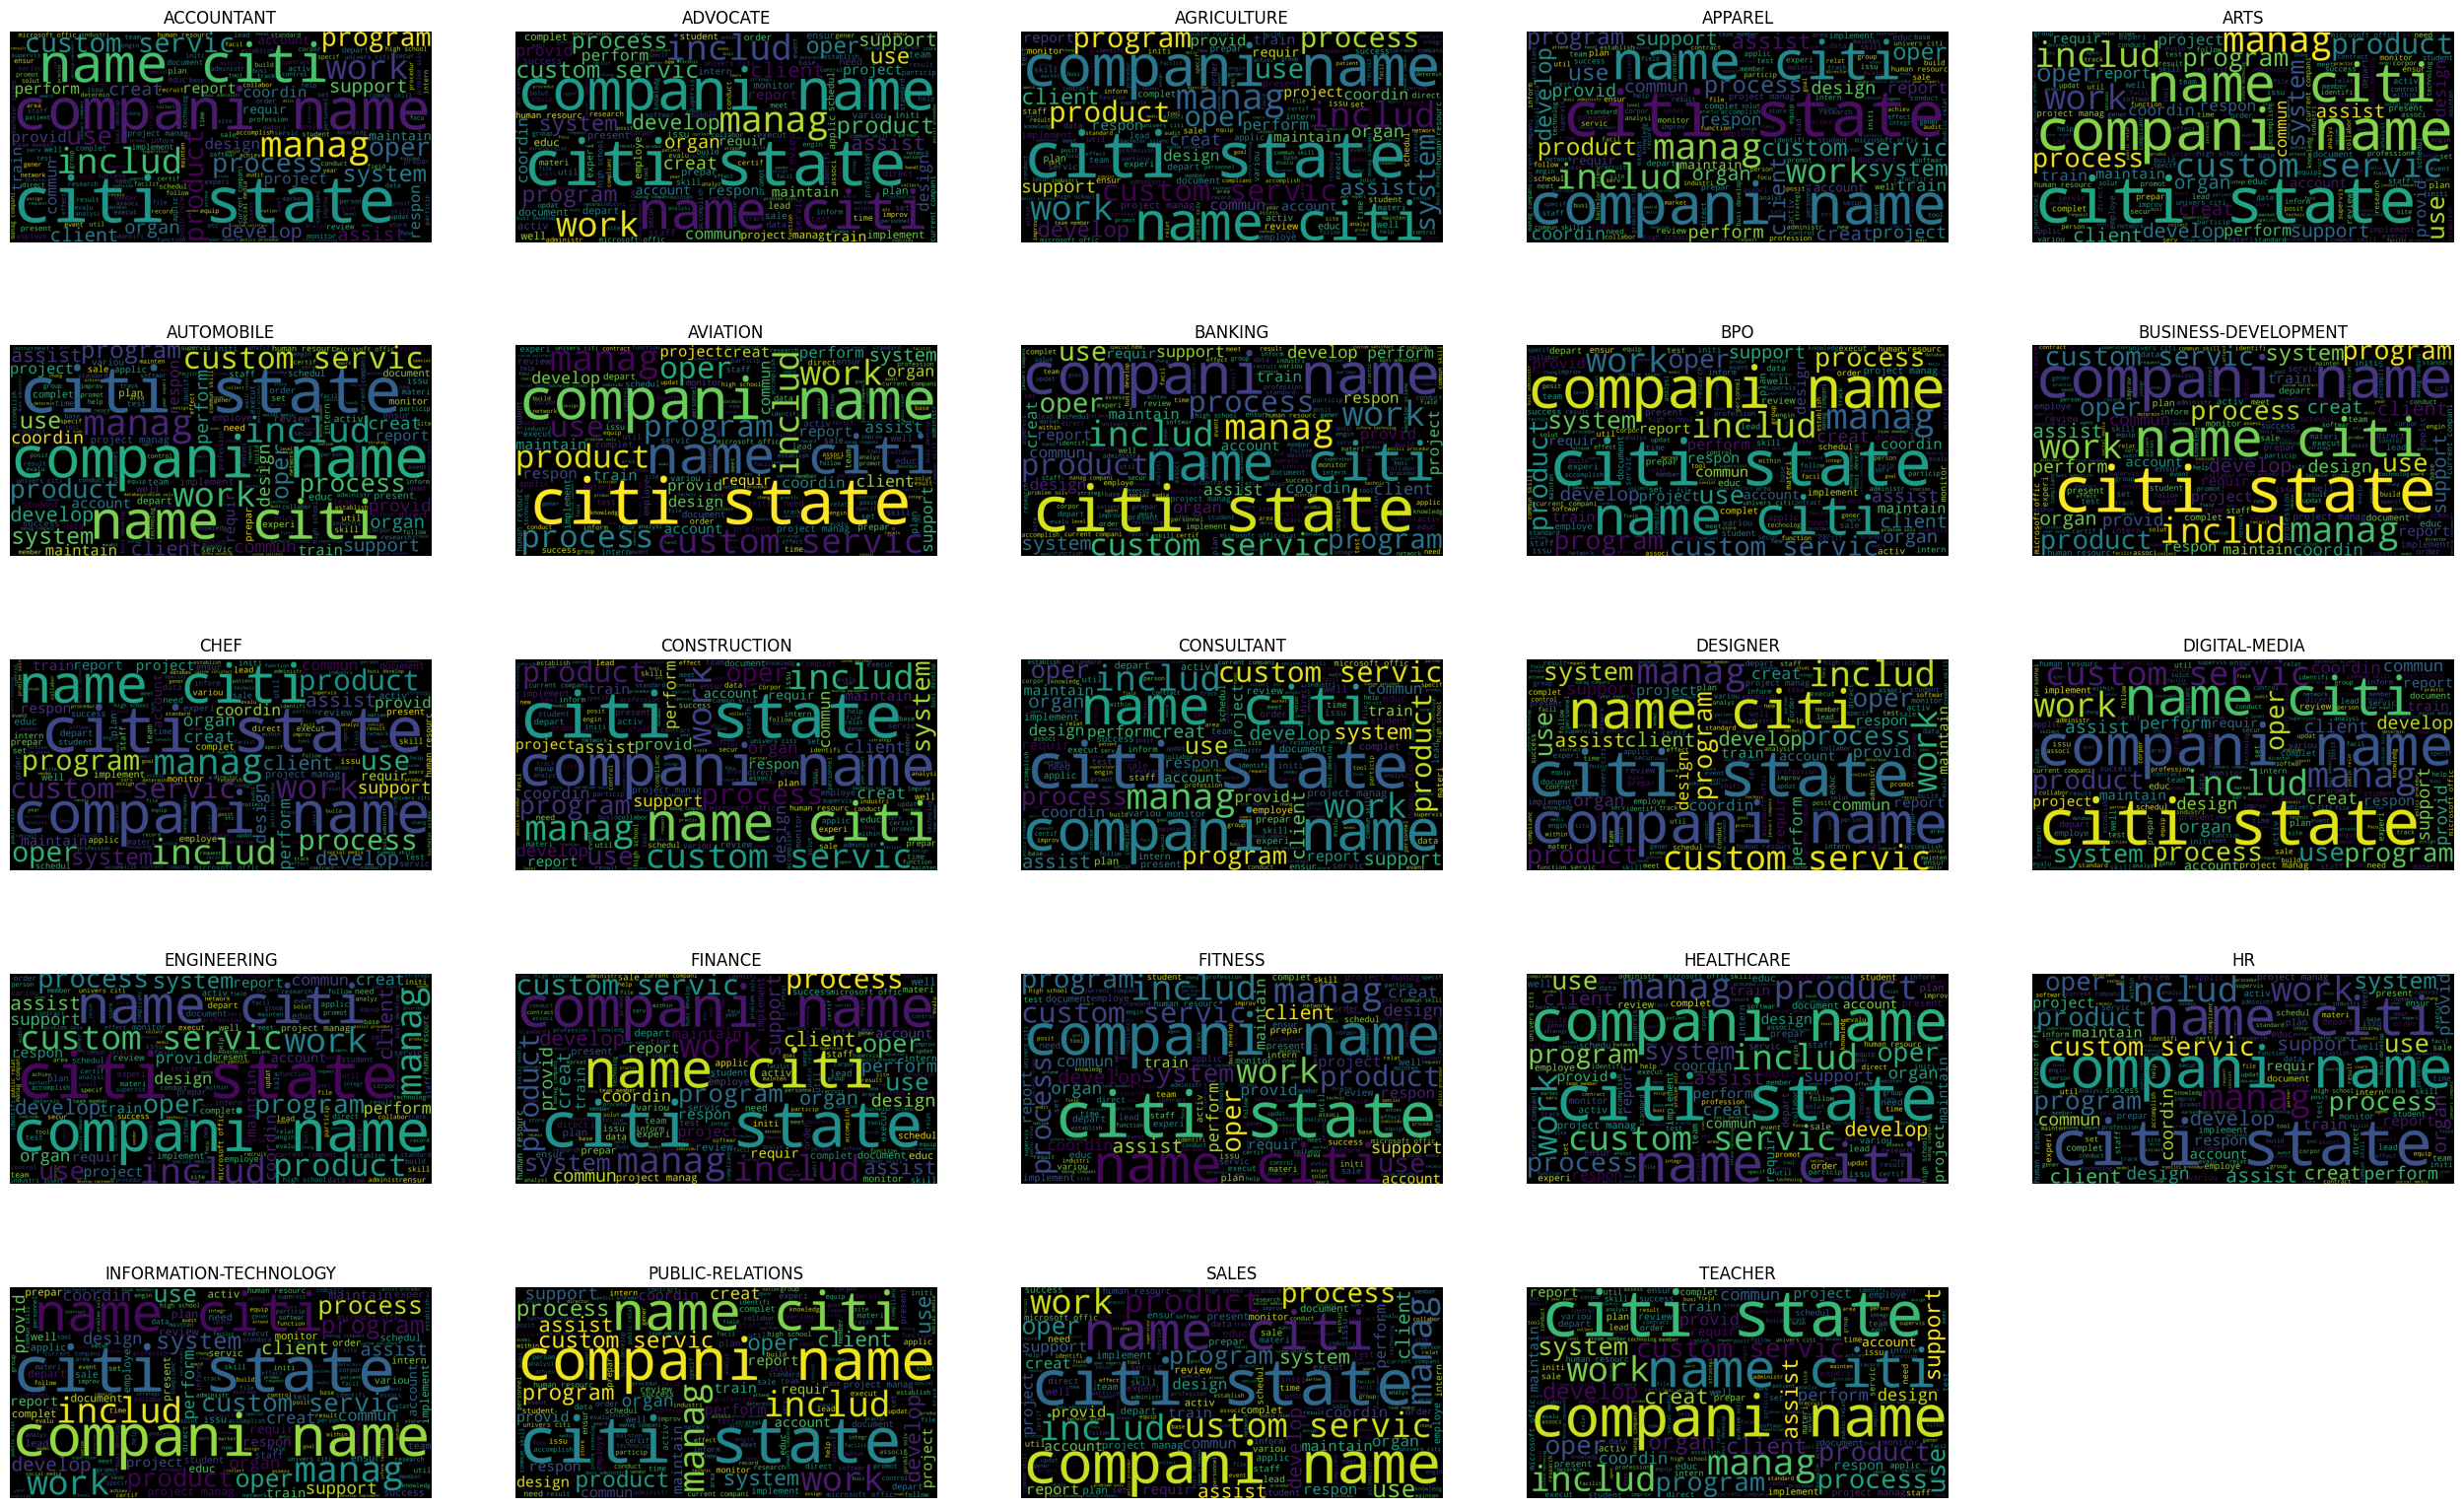

In [20]:
plt.figure(figsize=(32, 20))

for i, category in enumerate(categories):
    wc = wordcloud(df_categories[i])

    plt.subplot(5, 5, i + 1).set_title(category)
    plt.imshow(wc)
    plt.axis('off')
    plt.plot()

plt.show()
plt.close()

We see that this word cloud contains some words with huge numbers, but maybe it's not important for our training model. It may reduce our accuracy and increase losses when I run the model. So if we remove this word, may it be beneficial?

In [21]:
# try to remove extra word which are note important.
def remove_extra_word(text):

    extra_word=['compani', 'name', 'citi', 'state', 'work', 'manag'] # extra words
    words = text.split()  # Split the text into words

    # Filter out the extra words
    filter_word = [word for word in words if word not in extra_word]

    filter_text = ' '.join(filter_word)

    return filter_text


# apply resume_data['Cleaned_Resume']

resume_data['Cleaned_Resume']=resume_data['Cleaned_Resume'].apply(lambda x:remove_extra_word(x))




After cleaning the extra word, let's see how much well our word clouded.

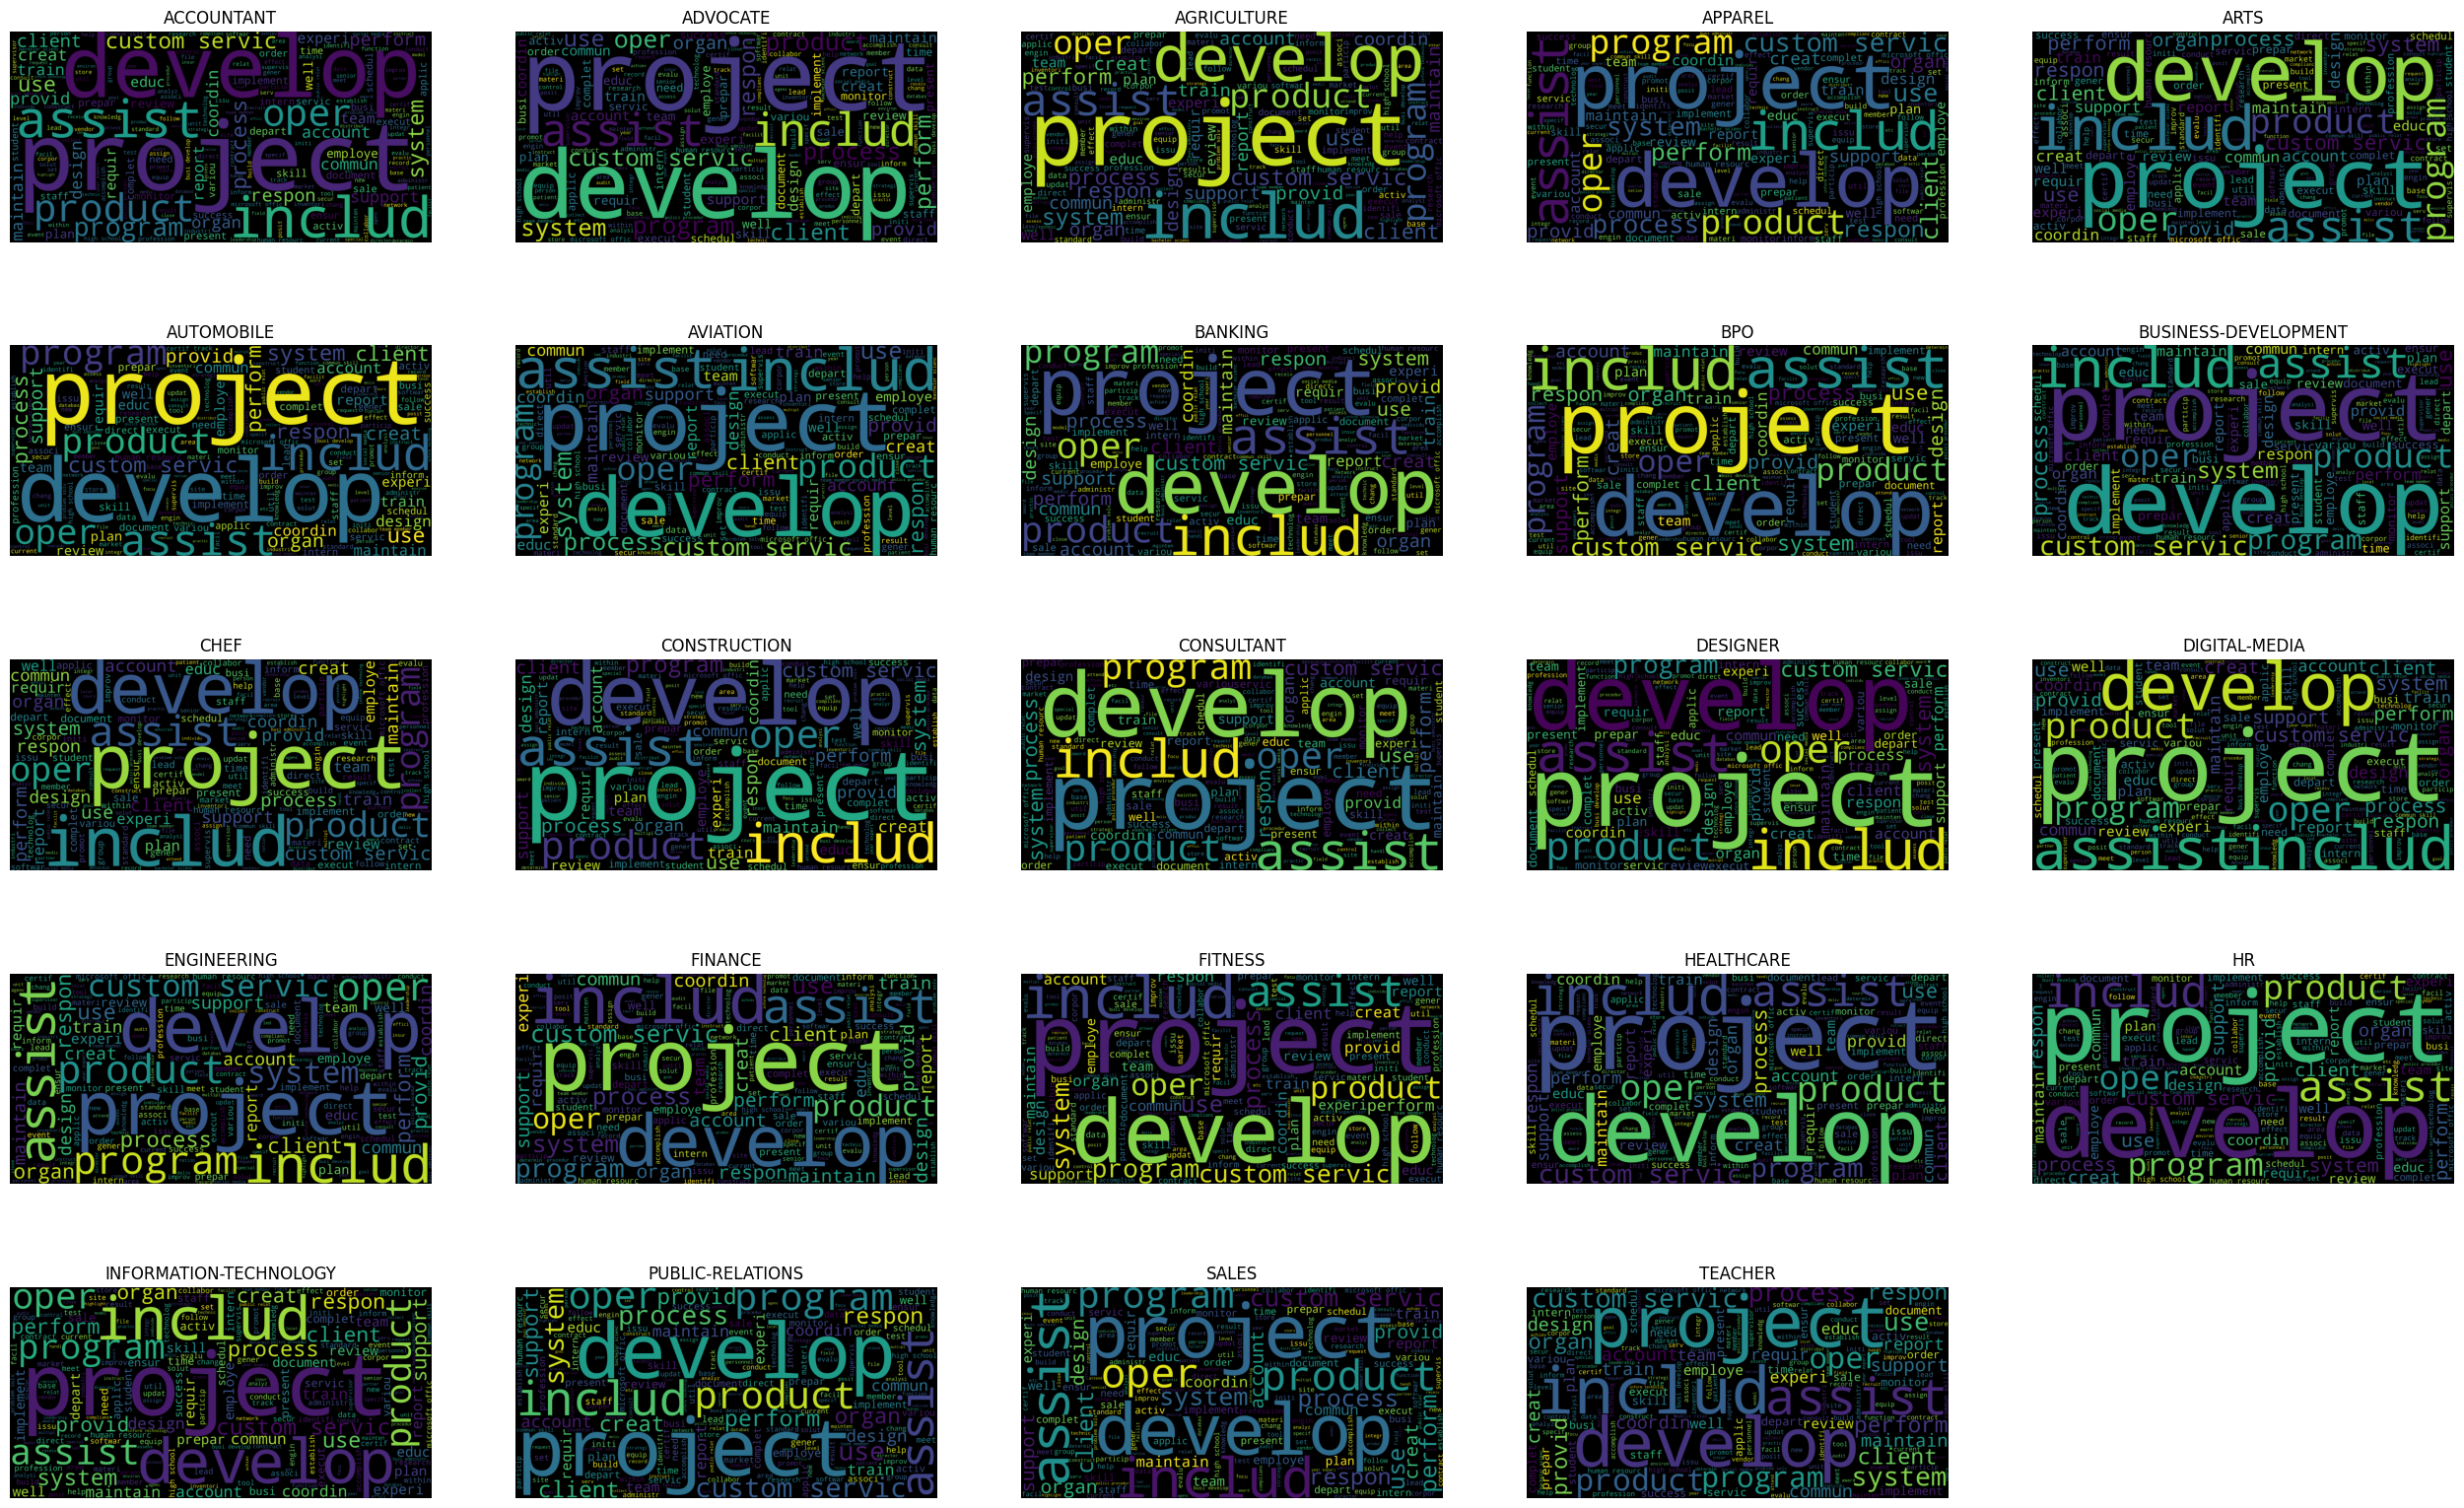

In [22]:
plt.figure(figsize=(32, 20))

for i, category in enumerate(categories):
    wc = wordcloud(df_categories[i])

    plt.subplot(5, 5, i + 1).set_title(category)
    plt.imshow(wc)
    plt.axis('off')
    plt.plot()

plt.show()
plt.close()

YES!!!, It's good. Here we see some words highlighted that are co-related to our category values.

<div style="color:Black; display:fill; border-radius:5px;background-color:#336b87;font-size:200%;font-family:sans-serif;letter-spacing:0.5px;text-align: center">Preprocessing and Encoding</div>

In the Encoding section, we employed Label Encoding to transform the categorical values in the 'Category' column into numerical representations. This facilitates the incorporation of categorical data into machine learning models.

In the text analysis section, we performed vectorization on the textual data using techniques such as TF-IDF (Term Frequency-Inverse Document Frequency) and Word2Vec. Vectorization converts the textual content into numerical vectors, enabling computational analysis and modeling on text-based data.

In [23]:
#now label encoding of Category columns

from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

In [24]:
# encoding and transfrom
resume_data['Category']=encoder.fit_transform(resume_data['Category'])

In [25]:
#now check is it work or not?
resume_data.head()

ID  Category                                     Cleaned_Resume
1443  16066857        10  senior execut chef execut profil seek employ e...
56    52979663        19  senior hr highlight safeti managementemploye e...
1131  15281412        12  consult summari transit applic develop secur p...
2472  16279537         6  supervisori logist specialist summari target f...
1710  24647794        15  engin intern profil profici entri level electr...

**YES!!!!!!!**, It's work.
**Congratulations** Everyone, We've done our first encoding process

In [26]:
# Now check all category value which are encoded by LabelEncoding
resume_data.Category.unique()

array([10, 19, 12,  6, 15,  7,  9,  1, 16, 14, 11, 18, 13,  2,  4, 17, 23,
       21,  3, 20,  0, 22,  8,  5])

<div style="color:Black; display:fill; border-radius:5px;background-color:#336b87;font-size:200%;font-family:sans-serif;letter-spacing:0.5px;text-align: center">Dataset Splitting</div>

In [27]:
# Split data into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(resume_data['Cleaned_Resume'], resume_data['Category'], test_size=0.15, random_state=42, stratify=resume_data['Category'])


# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_valid.shape)


Train data size: (1793,)
Validation data size: (317,)


Now our data set is separated into training, validation, and testing with respect to 72.2%, 12.8%, and 15%.

## Vectorization of TF-IDF

Now, we are vectorization the  "Cleaned_resume" column text using **TF-IDF (Term Frequency-Inverse Document Frequency)**.
TF-IDF is a numerical representation used in natural language processing and information retrieval to measure the importance of a word within a document relative to a collection of documents. It combines the frequency of a term (word) in a document (TF) with its rarity across the entire document collection (IDF).

In [28]:
#import TfidfVectorizer for vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
# create tf-idf model. and set te max_fatures 800.
tfidf=TfidfVectorizer(stop_words='english',max_features=800)

In [30]:
#fit and transfrom all dataset
tfidf_train_vectors = tfidf.fit_transform(X_train)
tfidf_valid_vectors =tfidf.transform(X_valid)

In [31]:
tfidf_train_vectors.shape

(1793, 800)

In [ ]:
# check vocabulary
#tfidf.vocabulary_

In [32]:
# extracting feature names
tfidf.get_feature_names_out()

array(['abil', 'abl', 'academ', 'accept', 'access', 'accomplish',
       'accord', 'account', 'accur', 'accuraci', 'achiev', 'acquisit',
       'act', 'action', 'activ', 'ad', 'adapt', 'addit', 'address',
       'adher', 'adjust', 'administ', 'administr', 'adob', 'advanc',
       'advertis', 'advis', 'advoc', 'affili', 'agenc', 'agent',
       'agreement', 'aid', 'air', 'aircraft', 'align', 'allow', 'america',
       'american', 'analysi', 'analyst', 'analyt', 'analyz', 'annual',
       'answer', 'appli', 'applic', 'appoint', 'approach', 'appropri',
       'approv', 'april', 'architectur', 'area', 'armi', 'arrang', 'art',
       'aspect', 'assembl', 'assess', 'asset', 'assign', 'assist',
       'associ', 'assur', 'attend', 'attent', 'audit', 'august', 'author',
       'autom', 'avail', 'averag', 'aviat', 'awar', 'award', 'bachelor',
       'background', 'balanc', 'bank', 'base', 'basi', 'basic',
       'behavior', 'benefit', 'best', 'board', 'book', 'branch', 'brand',
       'budget', 

<div style="color:Black; display:fill; border-radius:5px;background-color:#336b87;font-size:200%;font-family:sans-serif;letter-spacing:0.5px;text-align: center">Machine Learning Classifier</div>

In this study, We use to Basic Classifier which are related to work with Text such as (**Random Forest classifier,Logistic Regresssion,K-Nearest Neighbors,Naive Bayes and Support Vector Machine**) and also used advanced Technique such as (**Artificial Neural Network**).

In [33]:
# store all model and accuracy values
accuracy_lis=[]
model_lis=[]

## Random Forest classifier


In [35]:
#import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier



In [37]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(tfidf_train_vectors, y_train)

RandomForestClassifier()

## Logistic Regresssion

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
lr_classifier = LogisticRegression()
lr_classifier.fit(tfidf_train_vectors, y_train)

LogisticRegression()

## K-Nearest Neighbors

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
knn_classifier = KNeighborsClassifier(n_neighbors=24)
knn_classifier.fit(tfidf_train_vectors, y_train)

KNeighborsClassifier(n_neighbors=24)

## Naive Bayes

Naive Bayes is highly effective for text analysis,  It's popular for tasks like topic categorization due to its efficiency and suitability for text classification. It excels when dealing with high-dimensional text data and offers interpretable results.

In [42]:
from sklearn.naive_bayes import MultinomialNB

In [43]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train_vectors, y_train)

MultinomialNB()

If I look at this classification report, then we see some class labels get zero or very poor values. That means this type of categorized resume is not well fit and trained. Let's go to another classifier, get any improvement or not?

# Support Vector Machine
SVMs (Support Vector Machines) are powerful for text analysis, handling high-dimensional data and finding optimal class separation.

In [59]:
from sklearn.svm import SVC
svm_classifier = SVC(probability=True)
#svm_classifier = SVC()
svm_classifier.fit(tfidf_train_vectors, y_train)


SVC(probability=True)

Also, the same problem in some classes is getting precision, recall, and f1 score value zero. if we look at the category name (2,5,8) or (AGRICULTURE, AUTOMOBILE, BPO) .

## Deep Learning Approach

Artificial Neural Networks (ANNs) are commonly applied to process and analyze text data by transforming textual input into numerical representations, enabling tasks like sentiment analysis, text generation, and language translation.

In [60]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import to_categorical

In [61]:
# Artificial Neural Network
num_classes = len(encoder.classes_)
y_train_label = to_categorical(y_train, num_classes=num_classes)
y_valid_label = to_categorical(y_valid, num_classes=num_classes)

model = Sequential()
model.add(Dense(1000, input_dim=tfidf_train_vectors.shape[1]))
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(tfidf_train_vectors.toarray(), y_train_label, epochs=50, batch_size=32, validation_data=(tfidf_valid_vectors.toarray(), y_valid_label))# Artificial Neural Network
num_classes = len(encoder.classes_)
y_train_label = to_categorical(y_train, num_classes=num_classes)
y_valid_label = to_categorical(y_valid, num_classes=num_classes)

model = Sequential()
model.add(Dense(1000, input_dim=tfidf_train_vectors.shape[1]))
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(tfidf_train_vectors.toarray(), y_train_label, epochs=50, batch_size=32, validation_data=(tfidf_valid_vectors.toarray(), y_valid_label))

Epoch 1/50
57/57 [==============================] - 1s 7ms/step - loss: 2.2464 - accuracy: 0.4233 - val_loss: 1.6062 - val_accuracy: 0.5489
Epoch 2/50
57/57 [==============================] - 0s 4ms/step - loss: 1.2167 - accuracy: 0.6620 - val_loss: 1.4374 - val_accuracy: 0.6120
Epoch 3/50
57/57 [==============================] - 0s 4ms/step - loss: 0.7534 - accuracy: 0.7741 - val_loss: 1.4341 - val_accuracy: 0.6183
Epoch 4/50
57/57 [==============================] - 0s 4ms/step - loss: 0.4227 - accuracy: 0.8868 - val_loss: 1.6164 - val_accuracy: 0.6025
Epoch 5/50
57/57 [==============================] - 0s 4ms/step - loss: 0.2041 - accuracy: 0.9420 - val_loss: 1.7917 - val_accuracy: 0.5868
Epoch 6/50
57/57 [==============================] - 0s 4ms/step - loss: 0.0973 - accuracy: 0.9794 - val_loss: 1.9866 - val_accuracy: 0.6088
Epoch 7/50
57/57 [==============================] - 0s 4ms/step - loss: 0.0448 - accuracy: 0.9922 - val_loss: 2.0430 - val_accuracy: 0.6057
Epoch 8/50
57/57 [==

## Creating the ensemble to predict with hard coding.

In [62]:
from sklearn.ensemble import VotingClassifier
ensemble_classifier = VotingClassifier(
    estimators=[
        ('rf', rf_classifier),
        ('lr', lr_classifier),
        ('knn', knn_classifier),
        ('nb', nb_classifier),
        ('svm', svm_classifier)
    ],
    voting='soft'
)

## Training and Testing the ensemble

In [65]:
ensemble_classifier.fit(tfidf_train_vectors, y_train)

# Make predictions using the ensemble classifier
ensemble_predictions = ensemble_classifier.predict(tfidf_valid_vectors)

# Get the top 3 predicted classes for each instance
top3_predictions = [encoder.classes_[prediction.argsort()[-3:][::-1]] for prediction in ensemble_classifier.predict_proba(tfidf_valid_vectors)]

# Evaluate accuracy
ensemble_accuracy = accuracy_score(y_valid, ensemble_predictions)
print(f'Ensemble Accuracy: {ensemble_accuracy:.4f}')



Ensemble Accuracy: 0.6246


In [66]:
# prediction new resume
import pickle
pickle.dump(tfidf,open('tfidf.pkl', 'wb'))
pickle.dump(ensemble_classifier,open('ensemble.pkl', 'wb'))